In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def CTfunction(a, glauert = False):
    """
    This function calculates the thrust coefficient as a function of induction factor 'a'
    'glauert' defines if the Glauert correction for heavily loaded rotors should be used; default value is false
    """
    CT = np.zeros(np.shape(a))
    CT = 4*a*(1-a)  
    if glauert:
        CT1=1.816;
        a1=1-np.sqrt(CT1)/2;
        CT[a>a1] = CT1-4*(np.sqrt(CT1)-1)*(1-a[a>a1])
    
    return CT

def ainduction(CT):
    """
    This function calculates the induction factor 'a' as a function of thrust coefficient CT 
    including Glauert's correction
    """
    a = np.zeros(np.shape(CT))
    CT1=1.816;
    CT2=2*np.sqrt(CT1)-CT1
    a[CT>=CT2] = 1 + (CT[CT>=CT2]-CT1)/(4*(np.sqrt(CT1)-1))
    a[CT<CT2] = 0.5-0.5*np.sqrt(1-CT[CT<CT2])
    return a

def PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, axial_induction):
    """
    This function calcualte steh combined tip and root Prandtl correction at agiven radial position 'r_R' (non-dimensioned by rotor radius), 
    given a root and tip radius (also non-dimensioned), a tip speed ratio TSR, the number lf blades NBlades and the axial induction factor
    """
    temp1 = -NBlades/2*(tipradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Ftip = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades/2*(rootradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Froot = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot*Ftip, Ftip, Froot

def loadBladeElement(vnorm, vtan, r_R, chord, twist, polar_alpha, polar_cl, polar_cd):
    """
    calculates the load in the blade element
    """
    vmag2 = vnorm**2 + vtan**2
    inflowangle = np.arctan2(vnorm,vtan)
    alpha = twist + inflowangle*180/np.pi
    cl = np.interp(alpha, polar_alpha, polar_cl)
    cd = np.interp(alpha, polar_alpha, polar_cd)
    lift = 0.5*vmag2*cl*chord
    drag = 0.5*vmag2*cd*chord
    fnorm = lift*np.cos(inflowangle)+drag*np.sin(inflowangle)
    ftan = lift*np.sin(inflowangle)-drag*np.cos(inflowangle)
    gamma = 0.5*np.sqrt(vmag2)*cl*chord
    return fnorm , ftan, gamma, alpha, inflowangle

In [3]:
def solveStreamtube(Uinf, r1_R, r2_R, rootradius_R, tipradius_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd, CT=0.75):
    """
    solve balance of momentum between blade element load and loading in the streamtube
    input variables:
    Uinf - wind speed at infinity
    r1_R,r2_R - edges of blade element, in fraction of Radius ;
    rootradius_R, tipradius_R - location of blade root and tip, in fraction of Radius ;
    Radius is the rotor radius
    Omega -rotational velocity
    NBlades - number of blades in rotor
    """
    Area = np.pi*((r2_R*Radius)**2-(r1_R*Radius)**2) #  area streamtube
    r_R = (r1_R+r2_R)/2 # centroide

    if type(CT) != np.ndarray:
        CT = np.array([CT])
    
    # initiatlize variables
    a = ainduction(CT) # axial induction
    aline = 0.0 # tangential induction factor
    density = 1.225 # [kg/m^3]
    Niterations = 100
    Erroriterations =0.00001 # error limit for iteration process, in absolute value of induction
    
    for i in range(Niterations):
        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate velocity and loads at blade element"
        # ///////////////////////////////////////////////////////////////////////
        Urotor = Uinf*(1-a) # axial velocity at rotor
        Utan = (1+aline)*Omega*r_R*Radius # tangential velocity at rotor
        W = Urotor**2 + Utan**2
        # calculate loads in blade segment in 2D (N/m)
        fnorm, ftan, gamma, alpha, inflowangle = loadBladeElement(Urotor, Utan, r_R,chord, twist, polar_alpha, polar_cl, polar_cd)
        load3Daxial =fnorm*Radius*(r2_R-r1_R)*NBlades # 3D force in axial direction
        load3Dtan =ftan*Radius*(r2_R-r1_R)*NBlades # 3D force in azimuthal/tangential direction (not used here)
      
        # ///////////////////////////////////////////////////////////////////////
        # //the block "Calculate velocity and loads at blade element" is done
        # ///////////////////////////////////////////////////////////////////////

        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        # // calculate thrust coefficient at the streamtube 
        thrust = load3Daxial
        power = load3Daxial*Urotor
        
        CT = load3Daxial/(0.5*Area*Uinf**2)
        CN = load3Dtan/(0.5*Area*Uinf**2)
        CQ = 0
        CP = power/(0.5*Area*Uinf**2)
        
        # calculate new axial induction, accounting for Glauert's correction
        anew =  ainduction(CT)
        
        # correct new axial induction with Prandtl's correction
        Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, Omega*Radius/Uinf, NBlades, anew);
        if (Prandtl < 0.0001): 
            Prandtl = 0.0001 # avoid divide by zero
        anew = anew/Prandtl # correct estimate of axial induction
        a = 0.75*a+0.25*anew # for improving convergence, weigh current and previous iteration of axial induction

        # calculate aximuthal induction
        aline = ftan*NBlades/(2*np.pi*Uinf*(1-a)*Omega*2*(r_R*Radius)**2)
        aline =aline/Prandtl # correct estimate of azimuthal induction with Prandtl's correction
        # ///////////////////////////////////////////////////////////////////////////
        # // end of the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        
        #// test convergence of solution, by checking convergence of axial induction
        if (np.abs(a-anew) < Erroriterations): 
            # print("iterations")
            # print(i)
            break
    #dQ = 4*np.pi*density*Uinf*Utan*aline*(1-a)*(r_R*Radius)**2*(r2_R - r1_R)*Radius - 0.5*density*W*NBlades*
    power = load3Daxial*Urotor

    return [r_R, alpha, inflowangle, a, aline, CT, CP, thrust, power]


In [4]:

def run(pitch, twist_factor, chord_factor):
    """ Optimizes the pitch, chord and twist angle w.r.t. Cp """
    import pandas as pd

    airfoil = 'polar_DU95W180.xlsx'
    data1=pd.read_excel(airfoil, header=1)
    data1.columns = ['alfa', 'cl', 'cd', 'cm']
    polar_alpha = data1['alfa'][:]
    polar_cl = data1['cl'][:]
    polar_cd = data1['cd'][:]

    # define flow conditions
    Uinf = 10 # unperturbed wind speed in m/s
    TSR = 6 # tip speed ratio
    Radius = 50
    Omega = Uinf*TSR/Radius
    NBlades = 3
    Area = np.pi*Radius**2
    TipLocation_R =  1
    RootLocation_R =  0.2

    # define the blade geometry
    delta_r_R = .01
    r_R = np.arange(RootLocation_R, TipLocation_R+delta_r_R/2, delta_r_R)
    
    # blade shape
    pitch = pitch # degrees
    chord_distribution = chord_factor*(3*(1-r_R)+1) # meters
    twist_distribution = twist_factor*(-14*(1-r_R))+pitch # degrees

    # solve BEM model
    results =np.zeros([len(r_R)-1,9]) 
    
    ### Find best inflow angle per blade section
    for i in range(len(r_R)-1):
        chord = np.interp((r_R[i]+r_R[i+1])/2, r_R, chord_distribution)
        twist = np.interp((r_R[i]+r_R[i+1])/2, r_R, twist_distribution)

        results[i,:] = solveStreamtube(Uinf, r_R[i], r_R[i+1], RootLocation_R, TipLocation_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd )
    total_thrust = results[:,7].sum()
    total_power = results[:,8].sum()
    CT = total_thrust/(0.5*Area*Uinf**2)
    CP = total_power/(0.5*Area*Uinf**3)
    
    return [CT, CP]

In [5]:
def optimize(pitch_range, twist_range, chord_range):
    import csv
    i = 0
    f = open('results_wind_turbine.csv', 'w')
    with f:
        writer = csv.writer(f)
        writer.writerows([["pitch", "twist_factor", "chord_factor", "CT", "CP"]])
        for pitch in pitch_range:
            for twist_factor in twist_range:
                for chord_factor in chord_range:
                    pitch, twist_factor, chord_factor = round(pitch,2), round(twist_factor, 2), round(chord_factor,2)
                    CT, CP = run(pitch, twist_factor, chord_factor)
                    writer.writerows([[pitch, twist_factor, chord_factor,
                                        round(CT,5), round(CP,5)]])
    return 'finished'


In [15]:
pitch_range = np.arange(-1, 7, 0.1)
twist_range = np.arange(0.5, 1.5, 0.1)
chord_range = np.arange(0.5, 1.5, 0.1)

results = optimize(pitch_range, twist_range, chord_range)

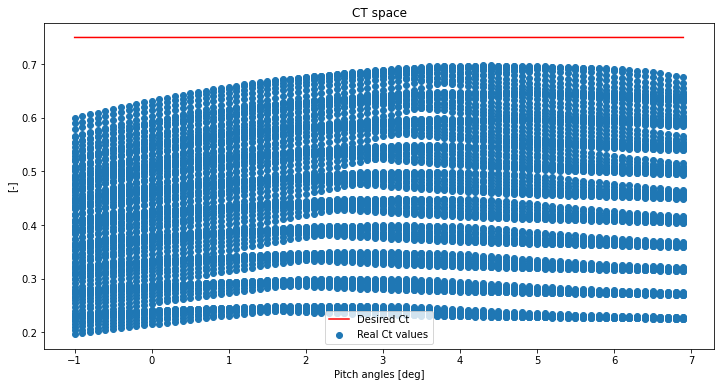

In [28]:
import pandas as pd
results = pd.read_csv('results_wind_turbine.csv')
fig1 = plt.figure(figsize=(12,6))
plt.scatter(results['pitch'], results['CT'], label='Real Ct values')
plt.plot(results['pitch'], np.ones(len(results))*0.75, 'r-', label='Desired Ct')
plt.xlabel('Pitch angles [deg]')
plt.ylabel('[-]')
plt.title('CT space')
plt.legend()
fig1.savefig('ct_space.png')


In [20]:
np.ones(len(results))*0.75


array([0.75, 0.75, 0.75, ..., 0.75, 0.75, 0.75])

In [114]:

def extended_run(pitch, twist_factor, chord_factor):
    """ Optimizes the pitch, chord and twist angle w.r.t. Cp """
    import pandas as pd

    airfoil = 'polar_DU95W180.xlsx'
    data1=pd.read_excel(airfoil, header=1)
    data1.columns = ['alfa', 'cl', 'cd', 'cm']
    polar_alpha = data1['alfa'][:]
    polar_cl = data1['cl'][:]
    polar_cd = data1['cd'][:]


    # define flow conditions
    Uinf = 10 # unperturbed wind speed in m/s
    TSR = 8 # tip speed ratio
    Radius = 50
    Omega = Uinf*TSR/Radius
    NBlades = 3
    Area = np.pi*Radius**2
    TipLocation_R =  1
    RootLocation_R =  0.2

    # define the blade geometry
    delta_r_R = .01
    r_R = np.arange(RootLocation_R, TipLocation_R+delta_r_R/2, delta_r_R)
    
    # blade shape
    pitch = pitch # degrees
    chord_distribution = chord_factor*(3*(1-r_R)+1) # meters
    twist_distribution = twist_factor*(-14*(1-r_R))+pitch # degrees
    
    # solve BEM model
    results =np.zeros([len(r_R)-1,9]) 
    
    ### Find best inflow angle per blade section
    for i in range(len(r_R)-1):
        chord = np.interp((r_R[i]+r_R[i+1])/2, r_R, chord_distribution)
        twist = np.interp((r_R[i]+r_R[i+1])/2, r_R, twist_distribution)

        results[i,:] = solveStreamtube(Uinf, r_R[i], r_R[i+1], RootLocation_R, TipLocation_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd )
    total_thrust = results[:,7].sum()
    total_power = results[:,8].sum()
    CT = total_thrust/(0.5*Area*Uinf**2)
    CP = total_power/(0.5*Area*Uinf**3)
    
    return results

In [118]:
results = pd.read_csv('results_wind_turbine.csv')
results['CP'].argmax()
best = results.iloc[47,:]
results = extended_run(pitch=best['pitch'], twist_factor=best['twist_factor'], chord_factor=best['chord_factor'])

In [119]:
best

pitch           2.20000
twist_factor    0.50000
chord_factor    1.00000
CT              0.75254
CP              0.51904
Name: 47, dtype: float64

In [121]:
TipLocation_R =  1
RootLocation_R =  0.2
delta_r_R=0.01
r_R = np.arange(RootLocation_R, TipLocation_R+delta_r_R/2, delta_r_R)
chord_distribution = best['chord_factor']*(3*(1-r_R)+1) # meters

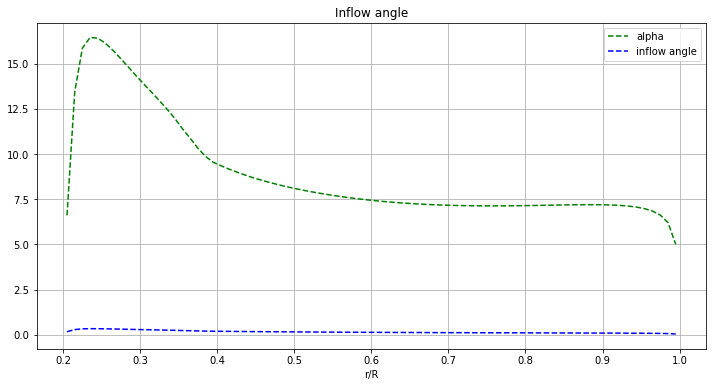

In [122]:
fig1 = plt.figure(figsize=(12, 6))
plt.title('Inflow angle')
plt.plot(results[:,0], results[:,1], 'g--', label='alpha')
plt.plot(results[:,0], results[:,2], 'b--', label='inflow angle')

plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()
fig1.savefig('wind_turbine_alpha_inflow_r_R.png')

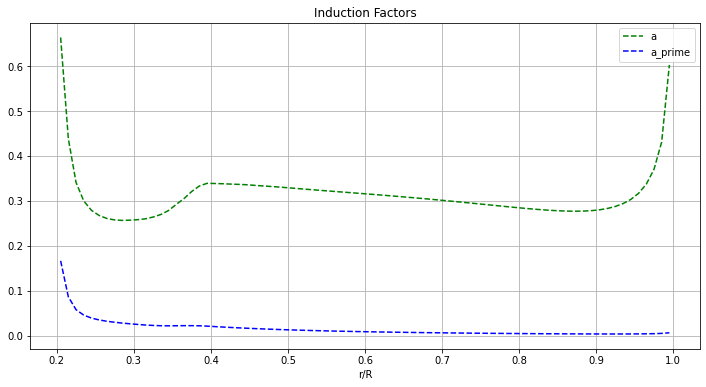

In [123]:
fig2 = plt.figure(figsize=(12, 6))
plt.title('Induction Factors')
plt.plot(results[:,0], results[:,3], 'g--', label='a')
plt.plot(results[:,0], results[:,4], 'b--', label='a_prime')

plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()
fig2.savefig('wind_turbine_a_aprime_r_R.png' )

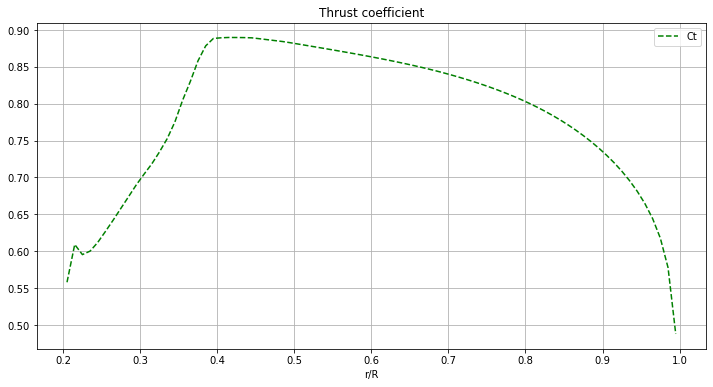

In [124]:
fig3 = plt.figure(figsize=(12, 6))
plt.title('Thrust coefficient')
plt.plot(results[:,0], results[:,5], 'g--', label='Ct')

plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()
fig3.savefig('wind_turbine_Ct_r_R.png')

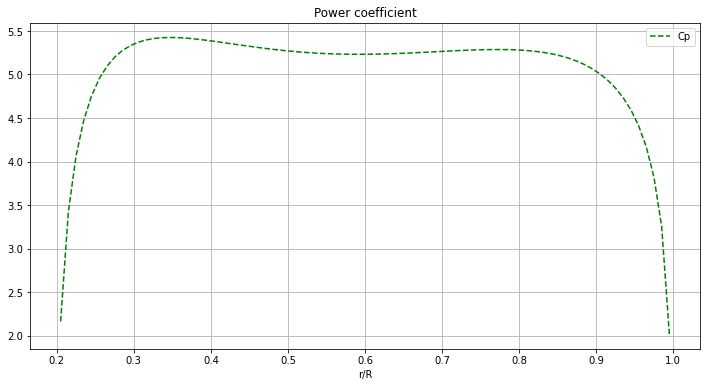

In [92]:
fig3 = plt.figure(figsize=(12, 6))
plt.title('Power coefficient')
plt.plot(results[:,0], results[:,6], 'g--', label='Cp')

plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()
fig3.savefig('wind_turbine_Cp_r_R.png' )

In [90]:
results[0]

array([2.05000000e-01, 3.34220956e+00, 2.56078365e-01, 5.11398363e-01,
       1.37903513e-01, 4.42895990e-01, 2.16400985e+00, 7.13091880e+02,
       3.48419919e+03])

In [94]:
results[0]

array([2.05000000e-01, 3.34220956e+00, 2.56078365e-01, 5.11398363e-01,
       1.37903513e-01, 4.42895990e-01, 2.16400985e+00, 7.13091880e+02,
       3.48419919e+03])